# Project 1 – Decision Trees and Random Forests

In [1]:
# Reload all modules without having to restart the kernel
# Useful for development if you have edited any of the external code files.
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
# ... add more imports as needed

# My implementations                                                
from decision_tree import DecisionTree
from random_forest import RandomForest

## Dataset

Do data loading, exploration and preprocessing as you see fit.

Here is some code to load the dataset to get you started.

In [2]:
data = np.genfromtxt("wine_dataset_small.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

value, counts = np.unique(y, return_counts=True)

print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(counts)

Feature columns names: ['citric_acid', 'residual_sugar', 'pH', 'sulphates', 'alcohol']
Target column name: type
X shape: (500, 5)
y shape: (500,)
[245 255]


Creating a boxplot of every feature

C:\Users\oskar\AppData\Local\Temp\ipykernel_4780\4269921884.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X, labels=feature_names)


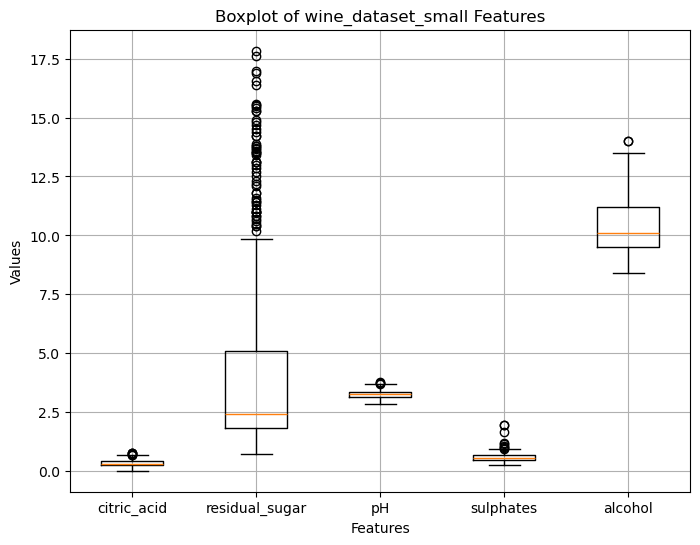

In [3]:
plt.figure(figsize=(8,6))
plt.boxplot(X, labels=feature_names)
plt.title('Boxplot of wine_dataset_small Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid(True)
plt.show()

Seeding to make sure results are reproducable, splitting data into training and test data and creating a KFold object with 5 folds

In [4]:
seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.2, random_state=seed, shuffle=True)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=seed)


Running K-fold cv to find the best hyperparameters for my tree implementation and sklearn decisiontreeclassifier

In [5]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
max_features = [None, 'sqrt', 'log2']
criterion = ['gini', 'entropy']

hyper_parameters = list(product(max_depths, max_features, criterion))

my_tree_validation_scores = []
sk_tree_validation_scores = []
my_accuracy_scores_by_depth = {depth: [] for depth in max_depths}
sk_accuracy_scores_by_depth = {depth: [] for depth in max_depths}

#Running k-fold cv
for max_depth, max_feature, criterion in hyper_parameters:
    my_cv_scores = []
    sk_cv_scores = []
    for train_idxs, val_idxs in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idxs], X_train[val_idxs]
        y_train_fold, y_val_fold = y_train[train_idxs], y_train[val_idxs]
        
        #Training and checking accuracy for my tree implementation
        own_tree = DecisionTree(max_depth=max_depth, max_features=max_feature, criterion=criterion)
        own_tree.fit(X_train_fold, y_train_fold)
        
        y_val_pred = own_tree.predict(X_val_fold)
        cv_score = accuracy_score(y_val_fold, y_val_pred)
        my_cv_scores.append(cv_score)

        #Training and checking accuracy for sklearn tree implementation
        sk_tree = DecisionTreeClassifier(max_depth=max_depth, max_features=max_feature, criterion=criterion, random_state=seed)
        sk_tree.fit(X_train_fold, y_train_fold)
        
        y_val_pred = sk_tree.predict(X_val_fold)
        cv_score = accuracy_score(y_val_fold, y_val_pred)
        sk_cv_scores.append(cv_score)

    cv_score = np.mean(my_cv_scores)
    my_tree_validation_scores.append(cv_score)
    my_accuracy_scores_by_depth[max_depth].append(cv_score)

    cv_score = np.mean(sk_cv_scores)
    sk_tree_validation_scores.append(cv_score)
    sk_accuracy_scores_by_depth[max_depth].append(cv_score)

#For plotting
my_avg_accuracy_scores_by_depth = {depth: np.mean(scores) for depth, scores in my_accuracy_scores_by_depth.items()}
sk_avg_accuracy_scores_by_depth = {depth: np.mean(scores) for depth, scores in sk_accuracy_scores_by_depth.items()}

#Finding best hyperparamaters
best_idx = np.argmax(my_tree_validation_scores)
my_tree_best_max_depth, my_tree_best_max_feature, my_tree_best_criterion = hyper_parameters[best_idx]
print(f"Best max_depth for my implementation: {my_tree_best_max_depth}")
print(f"Best max_feature for my implementation: {my_tree_best_max_feature}")
print(f"Best criterion for my implementation: {my_tree_best_criterion}")
print(f"Max validation accuract for my implementation: {my_tree_validation_scores[best_idx]:.5f}")

best_idx = np.argmax(sk_tree_validation_scores)
sk_tree_best_max_depth, sk_tree_best_max_feature, sk_tree_best_criterion = hyper_parameters[best_idx]
print(f"Best max_depth for sklearn: {sk_tree_best_max_depth}")
print(f"Best max_feature for sklearn: {sk_tree_best_max_feature}")
print(f"Best criterion for sklearn: {sk_tree_best_criterion}")
print(f"Max validation accuracy for sklearn: {sk_tree_validation_scores[best_idx]:.5f}")

Best max_depth for my implementation: 7
Best max_feature for my implementation: None
Best criterion for my implementation: gini
Max validation accuract for my implementation: 0.81500
Best max_depth for sklearn: 8
Best max_feature for sklearn: sqrt
Best criterion for sklearn: entropy
Max validation accuracy for sklearn: 0.84500


Plotting best max features per depth for both models

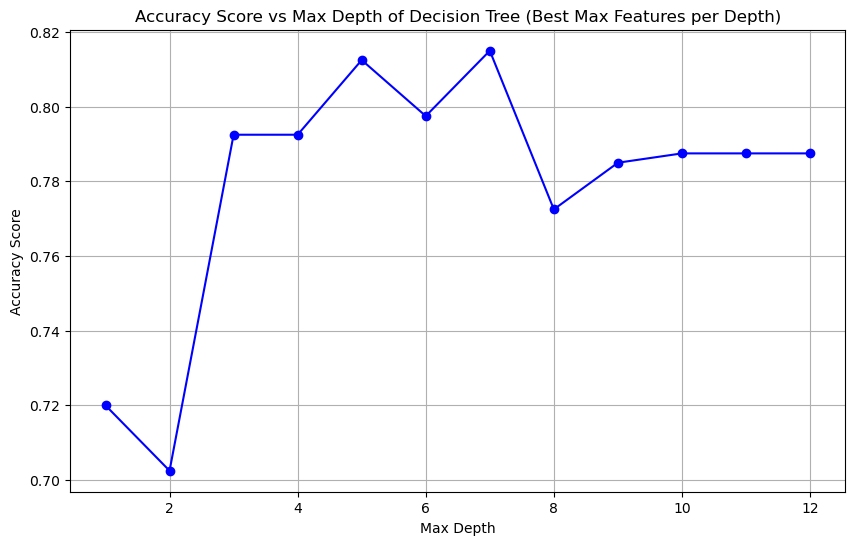

In [6]:
my_best_accuracy_scores_by_depth = {depth: max(scores) for depth, scores in my_accuracy_scores_by_depth.items()}

plt.figure(figsize=(10, 6))
plt.plot(max_depths, [my_best_accuracy_scores_by_depth[depth] for depth in max_depths], marker='o', linestyle='-', color='b')
plt.title('Accuracy Score vs Max Depth of Decision Tree (Best Max Features per Depth)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

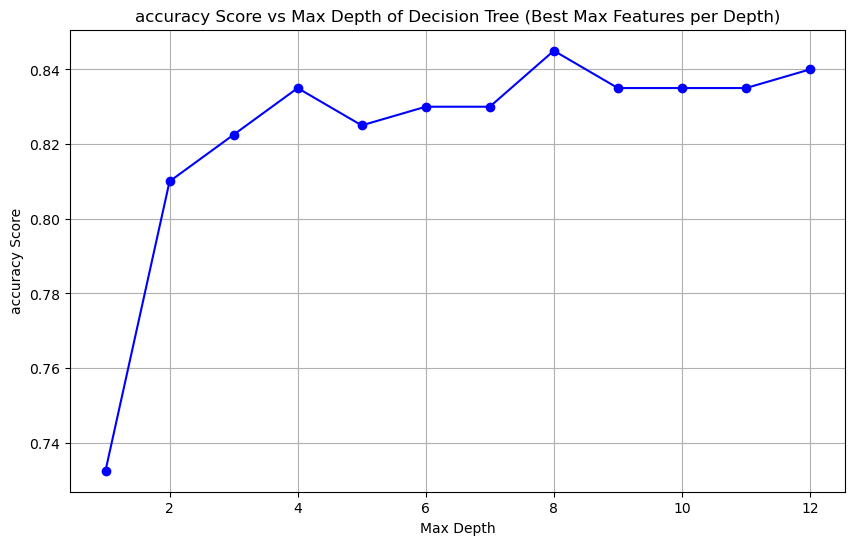

In [7]:
sk_best_accuracy_scores_by_depth = {depth: max(scores) for depth, scores in sk_accuracy_scores_by_depth.items()}

plt.figure(figsize=(10, 6))
plt.plot(max_depths, [sk_best_accuracy_scores_by_depth[depth] for depth in max_depths], marker='o', linestyle='-', color='b')
plt.title('accuracy Score vs Max Depth of Decision Tree (Best Max Features per Depth)')
plt.xlabel('Max Depth')
plt.ylabel('accuracy Score')
plt.grid(True)
plt.show()

Creating models with their best hyper parameters and checking test accuracy

In [8]:
#My model
my_tree_final_model = DecisionTree(max_depth=my_tree_best_max_depth, max_features=my_tree_best_max_feature, criterion=my_tree_best_criterion)
my_tree_final_model.fit(X_train, y_train)

tree_y_test_pred = my_tree_final_model.predict(X_test)
my_tree_test_accuracy = accuracy_score(y_test, tree_y_test_pred)
print(f"Test accuracy my tree: {my_tree_test_accuracy:.4f}")

#sklearn model
sk_tree_final_model = DecisionTreeClassifier(max_depth=sk_tree_best_max_depth, max_features=sk_tree_best_max_feature, random_state=seed, criterion=sk_tree_best_criterion)
sk_tree_final_model.fit(X_train, y_train)

tree_y_test_pred = sk_tree_final_model.predict(X_test)
sk_tree_test_accuracy = accuracy_score(y_test, tree_y_test_pred)
print(f"Test accuracy sklearn tree: {sk_tree_test_accuracy:.4f}")

Test accuracy my tree: 0.7900
Test accuracy sklearn tree: 0.8300


Using k-fold cv to find the best hyperparameters for my random forrest implementation and sklearn RandomForrestClassifier

In [17]:
n_estimators = list([10, 50, 100])
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
max_features = [None, 'sqrt', 'log2']
criterion = ['gini', 'entropy']

hyper_parameters_forrest = list(product(n_estimators, max_depths, max_features, criterion))

#Runninng cv
my_forrest_validation_scores = []
sk_forrest_validation_scores = []
for n_estimators, max_depths, max_feature, criterion in hyper_parameters_forrest:
    my_cv_scores = []
    sk_cv_scores = []
    for train_idxs, val_idxs in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idxs], X_train[val_idxs]
        y_train_fold, y_val_fold = y_train[train_idxs], y_train[val_idxs]
        
        my_forrest = RandomForest(n_estimators=n_estimators, max_depth=max_depths, max_features=max_feature, criterion=criterion)
        my_forrest.fit(X_train_fold, y_train_fold)
        y_val_pred = my_forrest.predict(X_val_fold)
        cv_score = accuracy_score(y_val_fold, y_val_pred)
        my_cv_scores.append(cv_score)

        sk_forrest = RandomForestClassifier(n_estimators=n_estimators, max_features=max_feature, max_depth=max_depths, random_state=seed, criterion=criterion)
        sk_forrest.fit(X_train_fold, y_train_fold)
        y_val_pred = sk_forrest.predict(X_val_fold)
        cv_score = accuracy_score(y_val_fold, y_val_pred)
        sk_cv_scores.append(cv_score)

    cv_score = np.mean(my_cv_scores)
    my_forrest_validation_scores.append(cv_score)
    
    cv_score = np.mean(sk_cv_scores)
    sk_forrest_validation_scores.append(cv_score)

#Checking best hyper params for my forrest
best_idx = np.argmax(my_forrest_validation_scores)
my_forrest_best_n_estimators, my_forrest_best_max_depth, my_forrest_best_max_feature, my_forest_best_criterion = hyper_parameters_forrest[best_idx]
print(f"Best n_estimators my forrest: {my_forrest_best_n_estimators}")
print(f"Best max_depth my forrest: {my_forrest_best_max_depth}")
print(f"Best max_feature my forrest: {my_forrest_best_max_feature}")
print(f"Best criterion my forrest: {my_forest_best_criterion}")
print(f"Max validation accuracy my forrest: {my_forrest_validation_scores[best_idx]:.5f}")

#Checking best hyper params for sklearn forrest
best_idx = np.argmax(sk_forrest_validation_scores)
sk_forrest_best_n_estimators, sk_forrest_best_max_depth, sk_forrest_best_max_feature, sk_forest_best_criterion = hyper_parameters_forrest[best_idx]
print(f"Best n_estimators sklearn forrest: {sk_forrest_best_n_estimators}")
print(f"Best max_depth sklearn forrest: {sk_forrest_best_max_depth}")
print(f"Best max_feature sklearn forrest: {sk_forrest_best_max_feature}")
print(f"Best criterion my forrest: {sk_forest_best_criterion}")
print(f"Max validation accuracy sklearn forrest: {sk_forrest_validation_scores[best_idx]:.5f}")

Best n_estimators my forrest: 10
Best max_depth my forrest: 6
Best max_feature my forrest: None
Best criterion my forrest: entropy
Max validation accuracy my forrest: 0.84179
Best n_estimators sklearn forrest: 50
Best max_depth sklearn forrest: 6
Best max_feature sklearn forrest: log2
Best criterion my forrest: gini
Max validation accuracy sklearn forrest: 0.84478


Checking test accuracy for my forrest and sklearn forrest

In [19]:
#My forrest
my_final_model = RandomForest(n_estimators=my_forrest_best_n_estimators, max_depth=my_forrest_best_max_depth, 
                              max_features=my_forrest_best_max_feature, criterion=my_forest_best_criterion)
my_final_model.fit(X_train, y_train)
y_test_pred = my_final_model.predict(X_test)

my_test_f1 = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy my forrest: {my_test_f1:.5f}")

#Sklearn forrest
sk_final_model = RandomForestClassifier(n_estimators=sk_forrest_best_n_estimators, max_depth=sk_forrest_best_max_depth, 
                                        max_features=sk_forrest_best_max_feature, criterion=sk_forest_best_criterion,
                                        random_state=seed)
sk_final_model.fit(X_train, y_train)
y_test_pred = sk_final_model.predict(X_test)

test_f1 = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy sklearn forrest: {test_f1:.5f}")

Test accuracy my forrest: 0.83333
Test accuracy sklearn forrest: 0.80952


Loading coffee dataset

In [11]:
data = np.genfromtxt("coffee_data.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

value, counts = np.unique(y, return_counts=True)
print(counts)

Feature columns names: ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Sweetness']
Target column name: CountryofOrigin
X shape: (419, 8)
y shape: (419,)
[183 236]


Creating a boxplot of every feature

C:\Users\oskar\AppData\Local\Temp\ipykernel_4780\687397513.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X, labels=feature_names)


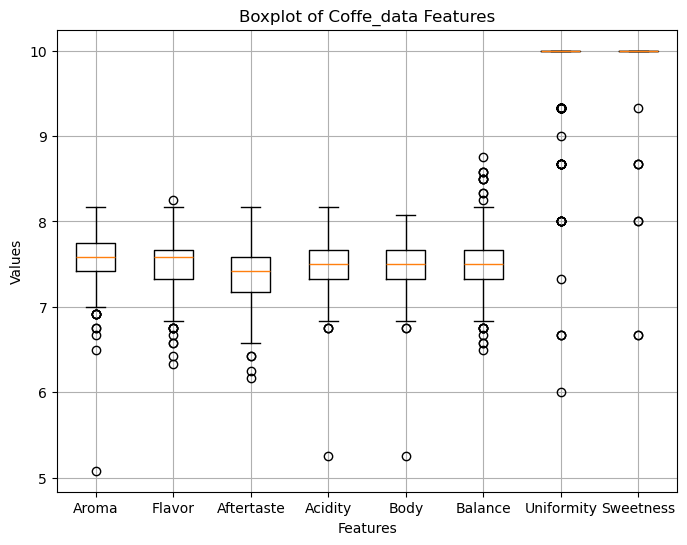

In [12]:
plt.figure(figsize=(8,6))
plt.boxplot(X, labels=feature_names)
plt.title('Boxplot of Coffe_data Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid(True)
plt.show()

Seeding, splitting data into test and training/validation and creating a kfold object with 5 folds

In [13]:
seed = 2
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.2, random_state=seed, shuffle=True)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

Finding best hyperparamaters for my DecisionTree and checking test accuracy

In [14]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
max_features = [None, 'sqrt', 'log2']
criterion = ['gini', 'entropy']

hyper_parameters = list(product(max_depths, max_features, criterion))

#Running k-fold cv
tree_validation_scores = []
for max_depths, max_feature, criterion in hyper_parameters:
    cv_scores = []
    for train_idxs, val_idxs in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idxs], X_train[val_idxs]
        y_train_fold, y_val_fold = y_train[train_idxs], y_train[val_idxs]
        
        tree = DecisionTree(max_depth=max_depths, max_features=max_feature, criterion=criterion)
        tree.fit(X_train_fold, y_train_fold)
        
        y_val_pred = tree.predict(X_val_fold)
        cv_score = accuracy_score(y_val_fold, y_val_pred)
        cv_scores.append(cv_score)

    cv_score = np.mean(cv_scores)
    tree_validation_scores.append(cv_score)

#Finding best hyper params
best_idx = np.argmax(tree_validation_scores)
tree_best_max_depth, tree_best_max_feature, tree_best_criterion = hyper_parameters[best_idx]
print(f"Best max_depth: {tree_best_max_depth}")
print(f"Best max_feature: {tree_best_max_feature}")
print(f"Best criterion: {tree_best_criterion}")
print(f"Max validation accuracy: {tree_validation_scores[best_idx]:.5f}")

#Training tree with best params
tree_final_model = DecisionTree(max_depth=tree_best_max_depth, max_features=tree_best_max_feature, criterion=tree_best_criterion)
tree_final_model.fit(X_train, y_train)

#Checking test accuracy
tree_y_test_pred = tree_final_model.predict(X_test)
tree_test_accuracy = accuracy_score(y_test, tree_y_test_pred)
print(f"Test accuracy: {tree_test_accuracy:.5f}")

Best max_depth: 4
Best max_feature: None
Best criterion: gini
Max validation accuracy: 0.80299
Test accuracy: 0.84524


Finding best hyperparamaters for my RandomForrest and checking test accuracy

In [15]:
n_estimators = list([10, 50, 100])
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
max_features = [None, 'sqrt', 'log2']
criterion = ['gini', 'entropy']

hyper_parameters_forrest = list(product(n_estimators, max_depths, max_features, criterion))

#Running k-fold cv
forrest_validation_scores = []
for n_estimators, max_depths, max_feature, criterion in hyper_parameters_forrest:
    cv_scores = []
    for train_idxs, val_idxs in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idxs], X_train[val_idxs]
        y_train_fold, y_val_fold = y_train[train_idxs], y_train[val_idxs]
        
        forrest = RandomForest(n_estimators=n_estimators, max_depth=max_depths, max_features=max_feature, criterion=criterion)
        forrest.fit(X_train_fold, y_train_fold)
        
        y_val_pred = forrest.predict(X_val_fold)
        cv_score = accuracy_score(y_val_fold, y_val_pred)
        cv_scores.append(cv_score)

    cv_score = np.mean(cv_scores)
    forrest_validation_scores.append(cv_score)

#Checking best hyper params
best_idx = np.argmax(forrest_validation_scores)
forrest_best_n_estimators, forrest_best_max_depth, forrest_best_max_features, forrest_best_criterion = hyper_parameters_forrest[best_idx]
print(f"Best n_estimators: {forrest_best_n_estimators}")
print(f"Best max_depth: {forrest_best_max_depth}")
print(f"Best max_features: {forrest_best_max_features}")
print(f"Best criterion: {forrest_best_criterion}")
print(f"Max validation accuracy: {forrest_validation_scores[best_idx]:.5f}")

#Training forrest with best params
final_model = RandomForest(n_estimators=forrest_best_n_estimators, max_depth=forrest_best_max_depth, max_features=forrest_best_max_features, criterion=forrest_best_criterion)
final_model.fit(X_train, y_train)

#Checking best test accuracy
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.5f}")

Best n_estimators: 50
Best max_depth: 7
Best max_features: None
Best criterion: entropy
Max validation accuracy: 0.84179
Test accuracy: 0.80952
